# Watch Brand Classification with CNN and Zero-Shot CLIP

In diesem Abschnitt importiere ich alle Bibliotheken, die ich für mein Computer-Vision-Projekt benötige. Diese Imports bilden die Grundlage für mein Projekt, in dem ich Uhrenmarken auf Bildern klassifiziere und die Leistung meines Modells mit einem Zero-Shot-Modell vergleiche.

In [6]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from transformers import pipeline


2025-06-02 14:14:28.148100: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 14:14:28.175033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 14:14:28.432356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 14:14:28.584115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748873668.883425  121061 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748873668.97

In diesem Teil lade ich meine Metadaten aus der Datei metadata.csv und bereinige den Datensatz:
Zuerst lese ich die CSV-Datei mit pd.read_csv() ein, die Informationen wie Bildnamen und zugehörige Marken enthält.
Dann filtere ich alle Zeilen heraus, bei denen das dazugehörige Bild nicht im Ordner images/ vorhanden ist – das vermeidet Fehler beim späteren Training.
Anschließend ermittle ich mit value_counts(), wie oft jede Marke im Datensatz vorkommt.
Um sicherzustellen, dass mein Modell genug Trainingsbeispiele hat, behalte ich nur Marken bei, die mindestens 2 Bilder haben.
Danach setze ich den Index zurück (reset_index) und bereite die Markenlabels für das Training vor:
Dafür verwende ich LabelEncoder() aus Scikit-Learn, um die Markennamen in numerische Klassen (IDs) umzuwandeln.
Diese numerischen Werte speichere ich in einer neuen Spalte namens brand_encoded.
So stelle ich sicher, dass mein Datensatz sauber, konsistent und trainingsbereit ist.

In [7]:
# Load and clean metadata
df = pd.read_csv("metadata.csv")
df = df[df["image_name"].apply(lambda x: os.path.exists(os.path.join("images", x)))]
brand_counts = df["brand"].value_counts()
valid_brands = brand_counts[brand_counts >= 2].index
df = df[df["brand"].isin(valid_brands)].reset_index(drop=True)
le = LabelEncoder()
df["brand_encoded"] = le.fit_transform(df["brand"])


Train/Validation Split
Ich teile meine Daten in Trainings- und Validierungsdaten auf, um später das Modell auf unbekannten Daten testen zu können. Dafür verwende ich die Funktion train_test_split von scikit-learn. Ich setze 20 % der Daten für die Validierung ab (test_size=0.2). Außerdem sorge ich durch stratify=df["brand_encoded"] dafür, dass die Verteilung der Marken in beiden Datensätzen gleich bleibt. Das bedeutet, jede Marke ist prozentual ungefähr gleich häufig in Training und Validierung vertreten. Um reproduzierbare Ergebnisse zu bekommen, setze ich einen festen Zufallswert (random_state=42). Die aufgeteilten Datensätze speichere ich als CSV-Dateien, damit ich sie später leicht laden kann.

In [8]:
# Train/Validation split
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["brand_encoded"], random_state=42
)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)


In [9]:
# Number of classes
num_classes = train_df["brand_encoded"].nunique()
print("Number of classes:", num_classes)


Number of classes: 64


In [10]:
# ImageDataGenerator using OpenCV
class ImageDataGenerator(Sequence):
    def __init__(self, df, image_folder, batch_size=32, img_size=(128, 128)):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.labels = df['brand_encoded'].values
        self.image_names = df['image_name'].values

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_names[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        images = []
        for img_name in batch_images:
            img_path = os.path.join(self.image_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, self.img_size) / 255.0
                images.append(img)
        images = np.array(images)
        labels = to_categorical(batch_labels[:len(images)], num_classes=num_classes)
        return images, labels


In [11]:
# Initialize generators
train_gen = ImageDataGenerator(train_df, image_folder="images")
val_gen = ImageDataGenerator(val_df, image_folder="images")


In [12]:
# CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-02 14:14:40.249577: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
# Train the model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - accuracy: 0.0625 - loss: 4.3457 - val_accuracy: 0.2353 - val_loss: 3.2532
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 272ms/step - accuracy: 0.2656 - loss: 3.0921 - val_accuracy: 0.4765 - val_loss: 2.3885
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.4230 - loss: 2.4201 - val_accuracy: 0.5804 - val_loss: 1.8625
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.5173 - loss: 1.8516 - val_accuracy: 0.6412 - val_loss: 1.5526
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.5916 - loss: 1.5236 - val_accuracy: 0.6745 - val_loss: 1.3349
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 292ms/step - accuracy: 0.6728 - loss: 1.1566 - val_accuracy: 0.7039 - val_loss: 1.2207
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.6732 - loss: 1.1009 - val_accuracy: 0.7392 - val_loss: 1.1049
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.7475 - loss: 0.8390 - val_accu

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8095 - loss: 0.9528
Validation Accuracy: 79.22 %


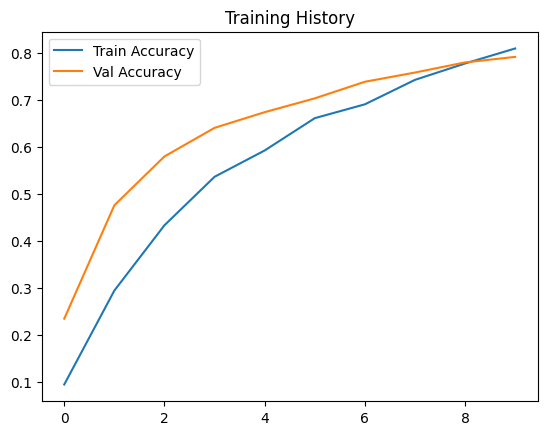

In [14]:
# Evaluate and plot
loss, acc = model.evaluate(val_gen)
print("Validation Accuracy:", round(acc * 100, 2), "%")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training History")
plt.show()


In [15]:
# Zero-shot classification using CLIP
zero_shot_detector = pipeline(model="openai/clip-vit-large-patch14", task="zero-shot-image-classification")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [16]:
model.save("watch_brand_classifier.h5", save_format='h5')


In [17]:
# Run zero-shot on a few images
candidate_labels = train_df['brand'].unique().tolist()
sample_df = val_df.sample(5, random_state=42)

for _, row in sample_df.iterrows():
    img_path = os.path.join("images", row["image_name"])
    image = Image.open(img_path).convert("RGB")
    result = zero_shot_detector(image, candidate_labels=candidate_labels)
    print(f"True: {row['brand']}, Predicted: {result[0]['label']}, Score: {result[0]['score']:.2f}")


True: Cluse, Predicted: Cluse, Score: 1.00
True: Daniel Wellington, Predicted: Daniel Wellington, Score: 1.00
True: Swatch, Predicted: Swatch, Score: 0.98
True: VERSUS Versace, Predicted: Versace, Score: 0.57
True: Nixon, Predicted: iConnect By Timex, Score: 0.95


In [18]:
import keras
print(keras.__version__)

3.10.0


In [19]:
import joblib
joblib.dump(le.classes_, "class_names.pkl")

['class_names.pkl']